# Lake Michigan Beach Study

In [1]:
#general imports
import rasterio
from rasterio import mask as msk
from shapely.geometry import mapping
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from osgeo import gdal

# Raster processing
import rsgislib
import rsgislib.imagecalc
import rsgislib.imagecalc.calcindices
from rsgislib import imageutils
import rsgislib.imageutils
import rsgislib.rastergis

# Regression Modeling
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

C:\Users\tschr\miniconda3\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\tschr\AppData\Local\Temp\ipykernel_25712\2528758555.py:7: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en

### Filepaths
#### Put filepath to data folder

In [2]:
#filepath = ''
#filepath = ''
filepath = 'C:\\Users\\tschr\\Desktop\\Landsat\\Data\\'
#output = ''
#output = ''
output = 'C:\\Users\\tschr\\Desktop\\Landsat\\Data\\output\\'

# Timothy Schragel

In [3]:
# set an imput filepath for landsat images
imagepath = filepath + '\\Images\\'


#Create a list of study area images
beach = []

year = 1986
for i in range(0,18):
    beach.append(imagepath + str(year) + ".TIF")
    year += 2
    

In [4]:
#Create an NDVI from each year's image
beach_ndvi = []

for i in range(0,18):
    
    #create the new name for the NDVI
    name = output + beach[i][-8:-4] + '_ndvi' + beach[i][-4:]
    
    #Use RSGISLIB to create NDVI's
    rsgislib.imagecalc.calcindices.calc_ndvi(beach[i], 3, 4, name, 
                                                    calc_stats=True, 
                                                    gdalformat='GTIFF')
    
    beach_ndvi.append(name)


In [5]:
#Create a classified layer where (sand = 1) and (dune = 2)
sandDuneList = []

for i in beach_ndvi:
    
    #create names for classified files
    name = output + i[-13:-9] + '_sandAndDune' + i[-4:]
    sandDuneList.append(name)
        
    #use RSGISLIB to create classified images
    band_defns = [rsgislib.imagecalc.BandDefn("ndvi", i, 1)]  
    exp = 'ndvi<-0.039?0:ndvi<=0.04?1:ndvi<0.05?0:ndvi>=0.25?0:2'
    rsgislib.imagecalc.band_math(name, exp, "GTIFF", 
                                        rsgislib.TYPE_8UINT, band_defns)
    rsgislib.imageutils.pop_thmt_img_stats(name,True,0.,True)
    year += 2
        

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.39it/s]


In [6]:
#Create a dataframe with pixle count for sand and dune, as well as percent of total pixles
d = pd.DataFrame({'TotalPixles':[], 'SandPixles':[], 'DunePixles':[], 'BothPixles':[], 
                  'BeachPixlesPercent':[], 'DunePixlesPercent':[], 'BothPixlesPercent':[]})
index = 0
for i in sandDuneList:
    src = rasterio.open(i)
    srcRead = src.read(1)
    unique, counts = np.unique(srcRead, return_counts=True)
    d.loc[index] = [counts[0], counts[1], counts[2], counts[1] + counts[2], 
                        (counts[1] / counts[0])*100, (counts[2] / counts[0])*100, 
                        ((counts[1] + counts[2]) / counts[0] )*100]
    index += 1
    
d.head()

,TotalPixles,SandPixles,DunePixles,BothPixles,BeachPixlesPercent,DunePixlesPercent,BothPixlesPercent
0,2084747.0,1572.0,3148.0,4720.0,0.075405,0.151002,0.226406
1,2083108.0,2304.0,4055.0,6359.0,0.110604,0.194661,0.305265
2,2083992.0,2122.0,3353.0,5475.0,0.101824,0.160893,0.262717
3,2079774.0,2272.0,7421.0,9693.0,0.109243,0.356818,0.466060
4,2084036.0,1881.0,3550.0,5431.0,0.090258,0.170343,0.260600


# Shauny Jackson

In [7]:
storm85 = pd.read_csv(filepath + '85data.csv')

In [8]:
#years 1985-2001
storm85 = pd.read_csv(filepath + "85data.csv")
# read CSV files 2002-2020
storm1 = pd.read_csv(filepath + "storm_data_01-01-2000_12-31-2005.csv")
storm2 = pd.read_csv(filepath + "storm_data_01-01-2006_12-31-2009.csv")
storm3 = pd.read_csv(filepath + "storm_data_01-01-2010_12-31-2012.csv")
storm4 = pd.read_csv(filepath + "storm_data_01-01-2013_12-31-2017.csv")
storm5 = pd.read_csv(filepath + "storm_data_01-01-2018_12-31-2020.csv")
storm02 = pd.concat([storm1, storm2, storm3, storm4, storm5], axis=0)

In [9]:
# change first dataset index to year
storm85 = storm85.set_index('year')
# calculate number of events
storm85['number_events'] = storm85.sum(axis = 1)
#drop month columns
storm85 = storm85.drop(['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'], axis=1)

In [10]:
# change column names to match first dataset
storm02.rename(columns={'BEGIN_DATE':'year', 'EVENT_ID': 'number_events'}, inplace=True)
# change date type from object to datetime
storm02['year'] = pd.to_datetime(storm02.year, format='%m/%d/%Y')
# selects winds with magnitude over 50
mag = storm02['MAGNITUDE'] >= 50
storm02 = storm02[mag]
# count dataset events by year
storm02 = storm02.groupby(storm02.year.dt.year)['number_events'].count()
storm02 = pd.DataFrame(storm02)

In [11]:
storms = pd.concat([storm85,storm02], axis=0)

In [12]:
stormdataset = {'year': ['1986','1988','1990','1992','1994','1996','1998','2000','2002','2004','2006','2008','2010','2012','2014','2016','2018','2020'],
               'number_of_events': [(storms.iloc[[0,1]].mean()['number_events']),(storms.iloc[[2,3]].mean()['number_events']),
                                 (storms.iloc[[4,5]].mean()['number_events']),(storms.iloc[[6,7]].mean()['number_events']),
                                 (storms.iloc[[8,9]].mean()['number_events']),(storms.iloc[[10,11]].mean()['number_events']),
                                 (storms.iloc[[12,13]].mean()['number_events']),(storms.iloc[[14,15]].mean()['number_events']),
                                 (storms.iloc[[16,17]].mean()['number_events']),(storms.iloc[[18,19]].mean()['number_events']),
                                 (storms.iloc[[20,21]].mean()['number_events']),(storms.iloc[[22,23]].mean()['number_events']),
                                 (storms.iloc[[24,25]].mean()['number_events']),(storms.iloc[[26,27]].mean()['number_events']),
                                 (storms.iloc[[28,29]].mean()['number_events']),(storms.iloc[[30,31]].mean()['number_events']),
                                 (storms.iloc[[32,33]].mean()['number_events']),(storms.iloc[[34,35]].mean()['number_events'])]}
stormdataset = pd.DataFrame(data=stormdataset)

stormdataset.head()

,year,number_of_events
0,1986,17.0
1,1988,30.5
2,1990,26.0
3,1992,24.5
4,1994,29.0


In [13]:
#import data
waterdata = pd.read_csv(filepath + "waterdata.csv")
waterdata = waterdata.drop(['month','Superior','St. Clair', 'Erie','Ontario'], axis=1)
waterdata.head()

,year,Michigan-Huron
0,1985,176.88
1,1985,176.86
2,1985,176.98
3,1985,177.14
4,1985,177.24


In [14]:
# Find yearly averages
waterdata = waterdata.groupby(waterdata['year']).mean()
water = waterdata.groupby(np.arange(len(waterdata))//2).mean()
water.head()

,Michigan-Huron
0,177.209583
1,176.767083
2,176.375417
3,176.474167
4,176.687083


In [15]:
year= ['1986','1988','1990','1992','1994','1996','1998','2000','2002','2004','2006','2008','2010','2012','2014','2016','2018','2020']
water.insert(0, 'year', year)
#water['year'] = year
water = water.rename(columns={'Michigan-Huron': 'water_level'})

In [16]:
water.head()

,year,water_level
0,1986,177.209583
1,1988,176.767083
2,1990,176.375417
3,1992,176.474167
4,1994,176.687083


In [17]:
#Storm and Water Level Dataset
storm_water = (pd.merge(water, stormdataset, on='year'))
storm_water.head()

,year,water_level,number_of_events
0,1986,177.209583,17.0
1,1988,176.767083,30.5
2,1990,176.375417,26.0
3,1992,176.474167,24.5
4,1994,176.687083,29.0


# Dalton Harris

In [18]:
# Read precipitation dataset old
#precipitation_dt = pd.read_csv('C:/Users/Dalton/Desktop/School/Winter_2023/GIS_490/Final_proj/data/Precipitation_final.csv')
#precipitation_dt.head()

In [19]:
# Read precipitation dataset new
precipitation_dt = pd.read_csv(filepath + 'Precipitation_final.csv')
precipitation_dt.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Annual
0,1985,2.17,4.78,3.50,2.00,1.97,3.47,3.49,4.40,2.81,3.27,9.00,2.37,43.23
1,1986,1.78,2.22,2.17,1.94,3.70,4.85,5.24,2.42,5.61,2.93,3.96,1.49,38.31
2,1987,2.13,0.50,0.91,2.13,5.08,3.24,4.76,6.94,3.23,4.43,1.65,5.45,40.45
3,1988,2.73,2.36,3.38,3.50,1.38,2.05,2.77,3.75,1.90,5.74,5.97,2.18,37.71
4,1989,1.43,1.49,2.16,2.33,3.40,4.23,2.98,4.58,4.29,1.94,3.53,2.92,35.28


In [20]:
#array Testing

In [21]:
#array for precip

In [22]:
#remove
#get precip dt without 1985
#remove1985_precip = precipitation_dt[precipitation_dt["Year"] != 1985]
#remove1985_precip

In [23]:
#remove
#only get the Annual precip column
#remove1985_precip_mean = remove1985_precip["Annual"]
#remove1985_precip_mean

In [24]:
#only get the Annual precip column
precip_annual = precipitation_dt["Annual"]
precip_annual.head()

0    43.23
1    38.31
2    40.45
3    37.71
4    35.28
Name: Annual, dtype: float64

In [25]:
#variable to mean of every N years
#N = 5
N = 2

In [26]:
# getting the precipitation average of every N (2) years
new_precip_df = precip_annual.groupby(precip_annual.index // N).mean()
new_precip_df.head()

0    40.770
1    39.080
2    48.745
3    46.645
4    43.055
Name: Annual, dtype: float64

In [27]:
#remove
#get an array for the mean every 5 years

#array_precip = remove1985_precip_mean.values.reshape(-1, N).mean(1)
#array_precip

In [28]:
#end array for precip

In [29]:
#get value for 1985, in order to add to array

In [30]:
#get only data for 1985
#only1985_precip = precipitation_dt[precipitation_dt["Year"] == 1985]
#only1985_precip

In [31]:
#only1985_precip_mean = only1985_precip["Annual"]
#only1985_precip_mean

In [32]:
#add the 1985 mean to the array : array_test    only1985_mean
#full_array_precip = np.append(only1985_precip_mean, array_precip)
#full_array_precip

In [33]:
#end adding 1985 mean to array

In [34]:
#turnning the array into a df

In [35]:
#array into a df
#new_precip_df = pd.DataFrame(full_array_precip, columns = ['5 year mean precip'])
#new_precip_df

In [36]:
#end making a dt for precip array

In [37]:
#create an array/dt with the years column

In [38]:
#create a year array
year_array = pd.array([1986, 1988, 1990, 1992, 1994, 1996, 1998,
                       2000, 2002, 2004, 2006, 2008, 2010,
                       2012, 2014, 2016, 2018, 2020])
year_array

<IntegerArray>
[1986, 1988, 1990, 1992, 1994, 1996, 1998, 2000, 2002, 2004, 2006, 2008, 2010,
 2012, 2014, 2016, 2018, 2020]
Length: 18, dtype: Int64

In [39]:
#create a df with years
new_year_df = pd.DataFrame(year_array, columns = ['year'])
new_year_df.head()

,year
0,1986
1,1988
2,1990
3,1992
4,1994


In [40]:
#end making a df with years

In [41]:
#join year df with precip df

In [42]:
#join with concat : new_year_df    new_precip_df
concat_df = pd.concat([new_year_df, new_precip_df], axis=1)
concat_df.head()

,year,Annual
0,1986,40.770
1,1988,39.080
2,1990,48.745
3,1992,46.645
4,1994,43.055


In [43]:
#read in ice data

In [44]:
# Read ice dataset old
#ice_dt = pd.read_csv('C:/Users/Dalton/Desktop/School/Winter_2023/GIS_490/Final_proj/data/max_ice_coverage.csv')
#ice_dt.head()

In [45]:
# Read precipitation dataset new
ice_dt = pd.read_csv(filepath + 'max_ice_coverage.csv')
ice_dt.head()

,year,cover,date
0,1985,41.3,23-Feb
1,1986,66.8,23-Feb
2,1987,20.0,21-Feb
3,1988,32.7,7-Feb
4,1989,30.9,19-Mar


In [46]:
#array for ice

In [47]:
#remove
#get ice dt without 1985
#remove1985_ice = ice_dt[ice_dt["year"] != 1985]
#remove1985_ice

In [48]:
#only get the cover (Annual) ice column
ice_cover = ice_dt["cover"]
ice_cover.head()

0    41.3
1    66.8
2    20.0
3    32.7
4    30.9
Name: cover, dtype: float64

In [49]:
# getting the precipitation average of every N (2) years
new_ice_df = ice_cover.groupby(ice_cover.index // N).mean()
new_ice_df.head()

0    54.05
1    26.35
2    31.65
3    27.15
4    57.45
Name: cover, dtype: float64

In [50]:
#remove
#get an ice array for the mean every 5 years
#array_ice_mean = remove1985_ice_mean.values.reshape(-1, N).mean(1)
#array_ice_mean

In [51]:
#end array for ice

In [52]:
#get value for 1985, in order to add to array

In [53]:
#remove
#get only data for 1985
#only1985_ice = ice_dt[ice_dt["year"] == 1985]
#only1985_ice

In [54]:
#remove
#get only cover
#only1985_ice_mean = only1985_ice["cover"]
#only1985_ice_mean

In [55]:
#remove
#add the 1985 ice mean to the ice array : array_ice_mean    only1985_ice_mean
#full_ice_array = np.append(only1985_ice_mean, array_ice_mean)
#full_ice_array

In [56]:
#end adding 1985 ice mean to array

In [57]:
#turnning the ice array into a df

In [58]:
#remove
#ice array into an ice df
#new_ice_df = pd.DataFrame(full_ice_array, columns = ['5 year mean ice'])
#new_ice_df

In [59]:
#end making a dt for precip array

In [60]:
#join concat_df df with ice df

In [61]:
#join with concat : new_year_df    new_precip_df
final_df = pd.concat([concat_df, new_ice_df], axis=1)
final_df.head()

,year,Annual,cover
0,1986,40.770,54.05
1,1988,39.080,26.35
2,1990,48.745,31.65
3,1992,46.645,27.15
4,1994,43.055,57.45


In [62]:
#end concat of df

# Final data tables

In [63]:
final_df = pd.concat([storm_water, new_ice_df, new_precip_df, d], axis=1)
final_df

,year,water_level,number_of_events,cover,Annual,TotalPixles,SandPixles,DunePixles,BothPixles,BeachPixlesPercent,DunePixlesPercent,BothPixlesPercent
0,1986,177.209583,17.0,54.05,40.770,2084747.0,1572.0,3148.0,4720.0,0.075405,0.151002,0.226406
1,1988,176.767083,30.5,26.35,39.080,2083108.0,2304.0,4055.0,6359.0,0.110604,0.194661,0.305265
2,1990,176.375417,26.0,31.65,48.745,2083992.0,2122.0,3353.0,5475.0,0.101824,0.160893,0.262717
3,1992,176.474167,24.5,27.15,46.645,2079774.0,2272.0,7421.0,9693.0,0.109243,0.356818,0.466060
4,1994,176.687083,29.0,57.45,43.055,2084036.0,1881.0,3550.0,5431.0,0.090258,0.170343,0.260600
5,1996,176.590833,30.5,48.30,41.565,2084124.0,1805.0,3538.0,5343.0,0.086607,0.169760,0.256367
6,1998,176.850417,37.5,26.45,38.510,2084304.0,1783.0,3380.0,5163.0,0.085544,0.162164,0.247709
7,2000,176.107083,35.5,25.10,39.185,2083460.0,2733.0,3274.0,6007.0,0.131176,0.157142,0.288318
8,2002,176.034583,34.5,20.95,39.525,2083320.0,2388.0,3759.0,6147.0,0.114625,0.180433,0.295058
9,2004,176.001250,28.5,42.20,38.755,2083140.0,2493.0,3834.0,6327.0,0.119675,0.184049,0.303724


In [64]:
waterLevel = 0
highWindEvents = 0
iceCover = 0
annualRainfall = 0
sandPix = 0
dunePix = 0

for i in range(0,18):
    waterLevel += final_df['water_level'][i]
    highWindEvents += final_df['number_of_events'][i]
    iceCover += final_df['cover'][i]
    annualRainfall += final_df['Annual'][i]
    sandPix += final_df['SandPixles'][i]
    dunePix += final_df['DunePixles'][i]
    

averageDF = pd.DataFrame({'annualRainfall':[], 'waterLevel':[],
                         'iceCover':[], 'highWindEvents':[]})

averageDF.loc[0] = [annualRainfall/18, waterLevel/18,
                   iceCover/18, highWindEvents/18]

averageDF

,annualRainfall,waterLevel,iceCover,highWindEvents
0,42.566944,176.448472,36.586111,27.111111


# Change Amount

In [65]:
sand = {}
dune = {}

it = 0
for i in final_df.iterrows():
    sand[int(i[1]['year'])]= i[1]['SandPixles']
    dune[int(i[1]['year'])]= i[1]['DunePixles']

In [66]:
print('Change in sand pixles from')
print('1986 to 2020')
print()
year = 1986
for i in range(len(sand) - 1):
    if (year + 2) == 1992:
        print(year,'to',year + 4 , ":", sand[year + 4] - sand[year])
    elif year == 1992:
        x = 1
    elif (year + 2) == 2018:
        print(year,'to',year + 4 , ":", sand[year + 4] - sand[year])
    elif year == 2018:
        x = 1
    else:
        print(year,'to',year + 2 , ":", sand[year + 2] - sand[year])
    year += 2

Change in sand pixles from
1986 to 2020

1986 to 1988 : 732.0
1988 to 1990 : -182.0
1990 to 1994 : -241.0
1994 to 1996 : -76.0
1996 to 1998 : -22.0
1998 to 2000 : 950.0
2000 to 2002 : -345.0
2002 to 2004 : 105.0
2004 to 2006 : 447.0
2006 to 2008 : -478.0
2008 to 2010 : -197.0
2010 to 2012 : 91.0
2012 to 2014 : 1608.0
2014 to 2016 : -2889.0
2016 to 2020 : 398.0


In [67]:
print('Change in dune pixles from')
print('1986 to 2020')
print()
year = 1986
for i in range(len(dune) - 1):
    if (year + 2) == 1992:
        print(year,'to',year + 4 , ":", dune[year + 4] - dune[year])
    elif year == 1992:
        x = 1
    elif (year + 2) == 2018:
        print(year,'to',year + 4 , ":", dune[year + 4] - dune[year])
    elif year == 2018:
        x = 1
    else:
        print(year,'to',year + 2 , ":", dune[year + 2] - dune[year])
    year += 2

Change in dune pixles from
1986 to 2020

1986 to 1988 : 907.0
1988 to 1990 : -702.0
1990 to 1994 : 197.0
1994 to 1996 : -12.0
1996 to 1998 : -158.0
1998 to 2000 : -106.0
2000 to 2002 : 485.0
2002 to 2004 : 75.0
2004 to 2006 : 475.0
2006 to 2008 : -279.0
2008 to 2010 : -420.0
2010 to 2012 : 14.0
2012 to 2014 : 2714.0
2014 to 2016 : -720.0
2016 to 2020 : 424.0


In [68]:
totchange = pd.DataFrame({'year':[],'SandChange':[],'DuneChange':[]})
year = 1986   
for i in range(len(sand) - 1):
    totchange.loc[i] = [(str(year) + '-' + str(year + 2)), sand[year + 2] - sand[year],dune[year + 2] - dune[year]]
    year += 2

print('This is the change per evey two years')
totchange

This is the change per evey two years


,year,SandChange,DuneChange
0,1986-1988,732.0,907.0
1,1988-1990,-182.0,-702.0
2,1990-1992,150.0,4068.0
3,1992-1994,-391.0,-3871.0
4,1994-1996,-76.0,-12.0
5,1996-1998,-22.0,-158.0
6,1998-2000,950.0,-106.0
7,2000-2002,-345.0,485.0
8,2002-2004,105.0,75.0
9,2004-2006,447.0,475.0


In [69]:
changedf = pd.DataFrame({'year':[],'SandChange':[],'DuneChange':[]})
year = 1986   
for i in range(len(sand) - 1):
    #some of our classifications were overclassifying land coverage so we removed those years
    #This was most likely due to some cloud coverage over our study area
    if  (year + 2) == 1992:
        changedf.loc[i] = [(str(year) + '-' + str(year + 4)), sand[year + 4] - sand[year],dune[year + 4] - dune[year]]
        year +=  4
    elif (year + 2) == 2014:
        changedf.loc[i] = [(str(year) + '-' + str(year + 4)), sand[year + 4] - sand[year],dune[year + 4] - dune[year]]
        year += 4        
    elif (year + 2) == 2018:
        changedf.loc[i] = [(str(year) + '-' + str(year + 4)), sand[year + 4] - sand[year],dune[year + 4] - dune[year]]
        year += 4
    elif year == 2020:
        x = 1
    else:
        changedf.loc[i] = [(str(year) + '-' + str(year + 2)), sand[year + 2] - sand[year],dune[year + 2] - dune[year]]
        year += 2
        
print("Change except for '92, '14, '18")
changedf

Change except for '92, '14, '18


,year,SandChange,DuneChange
0,1986-1988,732.0,907.0
1,1988-1990,-182.0,-702.0
2,1990-1994,-241.0,197.0
3,1994-1996,-76.0,-12.0
4,1996-1998,-22.0,-158.0
5,1998-2000,950.0,-106.0
6,2000-2002,-345.0,485.0
7,2002-2004,105.0,75.0
8,2004-2006,447.0,475.0
9,2006-2008,-478.0,-279.0


In [70]:
storedD = 0
storedS = 0
negDuneChange = 0
posDuneChange = 0
posSandChange = 0
negSandChange = 0


for i in range(len(changedf)):
    storedD += changedf['DuneChange'].iloc[i]
    storedS += changedf['SandChange'].iloc[i]
    
    if changedf['DuneChange'].iloc[i] < 0:
        negDuneChange += changedf['DuneChange'].iloc[i]
    elif changedf['DuneChange'].iloc[i] > 0:
        posDuneChange += changedf['DuneChange'].iloc[i]
        
    if changedf['SandChange'].iloc[i] < 0:
        negSandChange += changedf['SandChange'].iloc[i]
    elif changedf['SandChange'].iloc[i] > 0:
        posSandChange += changedf['SandChange'].iloc[i]
     
    
print('The total negative dune change is:', negDuneChange)
print('The total positive dune change is:', posDuneChange)
print('The average negative dune change is:', negDuneChange / len(changedf))
print('The average positive dune change is:', posDuneChange / len(changedf))
print('The average change in Dune pixel count is: ', (storedD / len(changedf)))
print()
print('The total negative sand change is:', negSandChange)
print('The total positive sand change is:', posSandChange)
print('The average negative sand change is:', negSandChange / len(changedf))
print('The average positive sand change is:', posSandChange / len(changedf))
print('The average change in Sand pixel count is: ', (storedS / len(changedf)))

The total negative dune change is: -1677.0
The total positive dune change is: 4571.0
The average negative dune change is: -119.78571428571429
The average positive dune change is: 326.5
The average change in Dune pixel count is:  206.71428571428572

The total negative sand change is: -2822.0
The total positive sand change is: 2723.0
The average negative sand change is: -201.57142857142858
The average positive sand change is: 194.5
The average change in Sand pixel count is:  -7.071428571428571


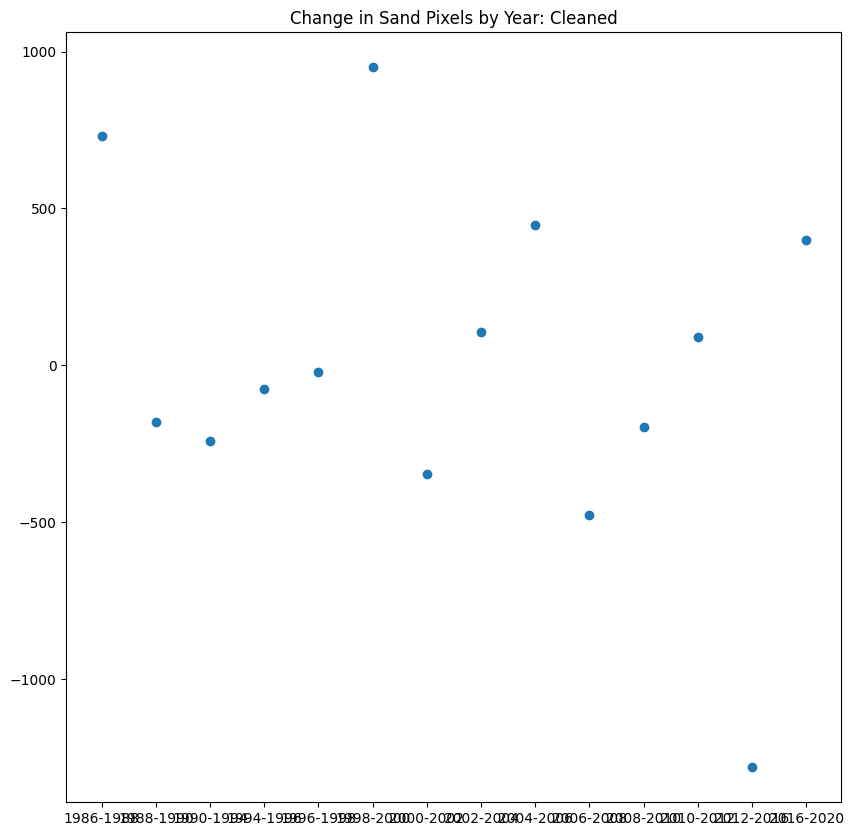

In [71]:
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(changedf['year'],changedf['SandChange'])
ax.set_title('Change in Sand Pixels by Year: Cleaned')

plt.show()

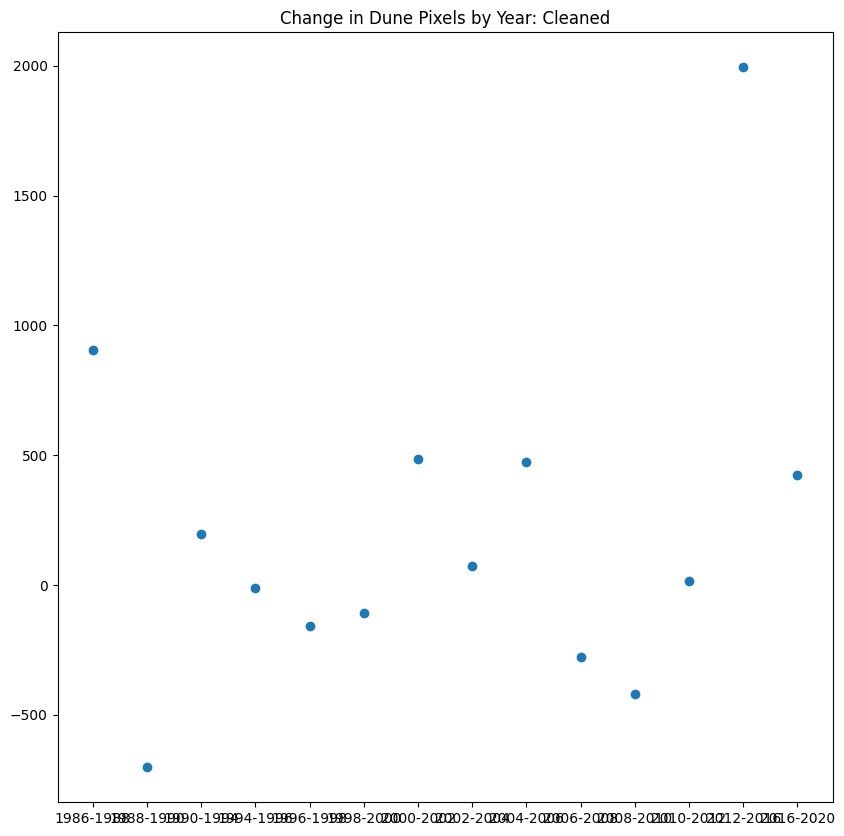

In [72]:
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(changedf['year'],changedf['DuneChange'])
ax.set_title('Change in Dune Pixels by Year: Cleaned')

plt.show()


# Visulizations

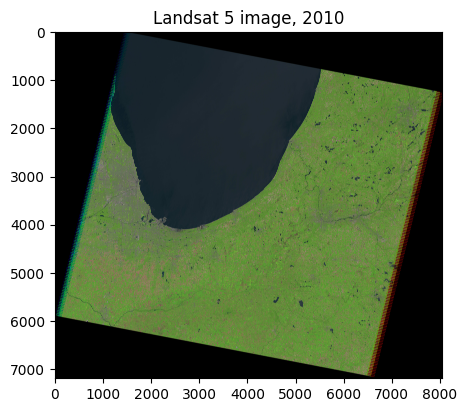

In [73]:
#studyArea = gpd.read_file(filepath + 'study.shp')
#studyArea.to_crs('EPSG:32616')
fullDataset = gdal.Open(filepath + '2010Full.tif')
fullBand1 = fullDataset.GetRasterBand(1)
fullB1 = fullBand1.ReadAsArray()
fullBand2 = fullDataset.GetRasterBand(2)
fullB2 = fullBand2.ReadAsArray()
fullBand3 = fullDataset.GetRasterBand(3)
fullB3 = fullBand3.ReadAsArray()
fullImg = np.dstack((fullB1, fullB2, fullB3))

fig, ax = plt.subplots(figsize=(5,5))

ax.imshow(fullImg)
ax.set_title('Landsat 5 image, 2010')
plt.show()

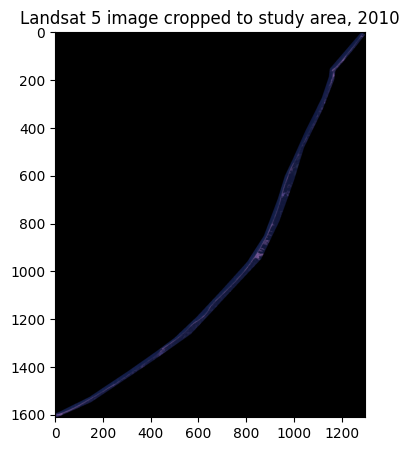

In [74]:
dataset = gdal.Open(filepath + 'Images\\2010.tif')
band1 = dataset.GetRasterBand(3)
b1 = band1.ReadAsArray()
band2 = dataset.GetRasterBand(2)
b2 = band2.ReadAsArray()
band3 = dataset.GetRasterBand(1)
b3 = band3.ReadAsArray()
img = np.dstack((b1, b2, b3))

fig, ax = plt.subplots(figsize=(5,5))

ax.imshow(img)
ax.set_title('Landsat 5 image cropped to study area, 2010')
plt.show()

# Scatter Plots

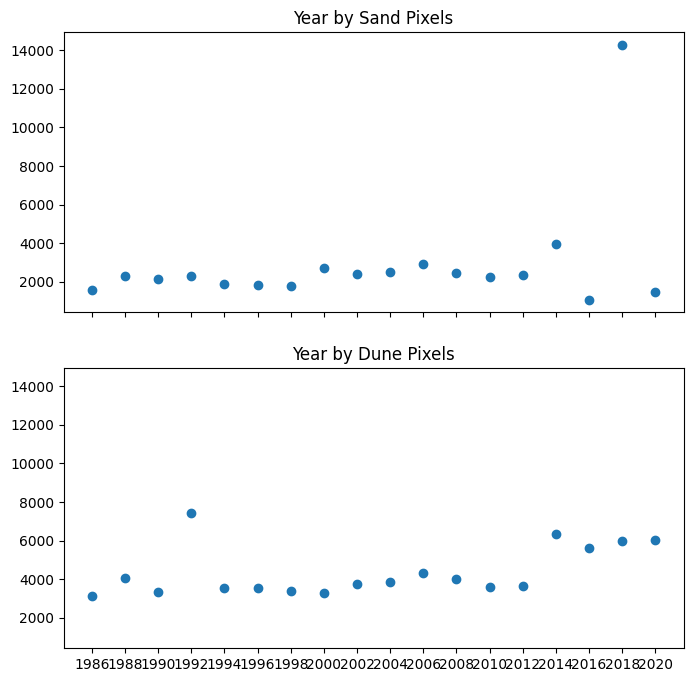

In [75]:
fig, ax = plt.subplots(2,1, sharey=True, sharex=True, figsize=(8,8))

ax[0].scatter(final_df['year'],final_df['SandPixles'])
ax[0].set_title('Year by Sand Pixels')
ax[1].scatter(final_df['year'],final_df['DunePixles'])
ax[1].set_title('Year by Dune Pixels')

plt.show()

In [76]:
f_df = final_df[(final_df['year'] != '1992') & (final_df['year'] != '2018')]

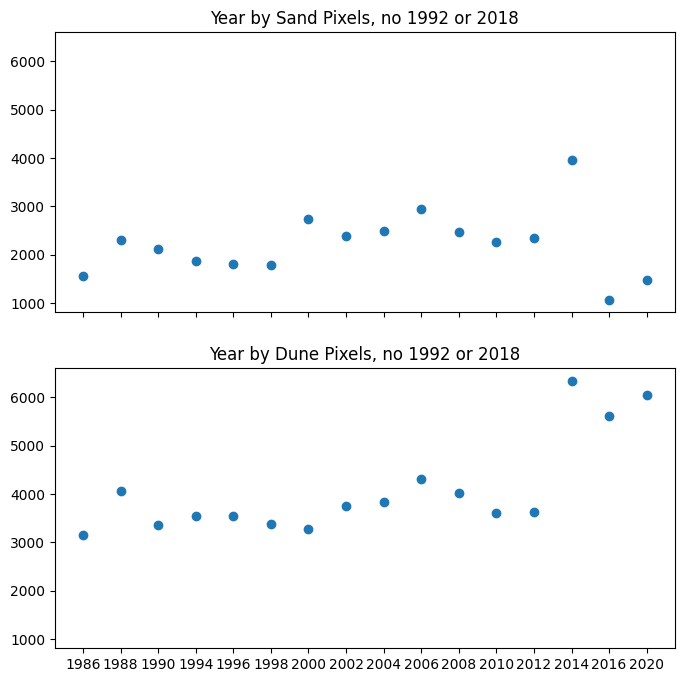

In [77]:
fig, ax = plt.subplots(2,1, sharey=True, sharex=True, figsize=(8,8))

ax[0].scatter(f_df['year'],f_df['SandPixles'])
ax[0].set_title('Year by Sand Pixels, no 1992 or 2018')
ax[1].scatter(f_df['year'],f_df['DunePixles'])
ax[1].set_title('Year by Dune Pixels, no 1992 or 2018')

plt.show()

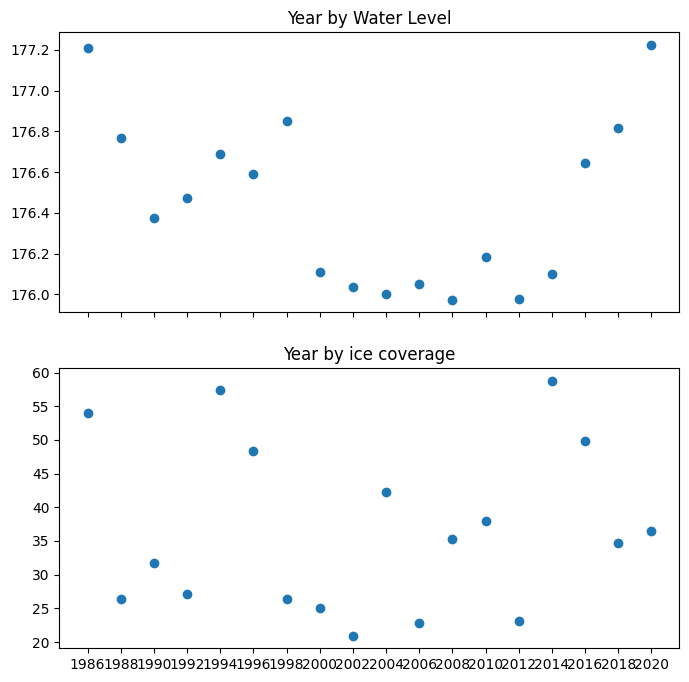

In [78]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(8,8))

ax[0].scatter(final_df['year'],final_df['water_level'])
ax[0].set_title('Year by Water Level')
ax[1].scatter(final_df['year'],final_df['cover'])
ax[1].set_title('Year by ice coverage')

plt.show()

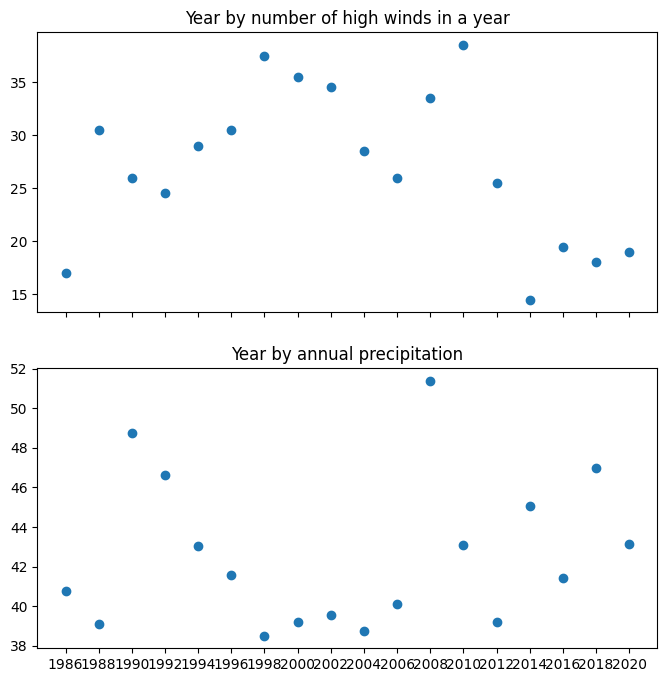

In [79]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(8,8))

ax[0].scatter(final_df['year'],final_df['number_of_events'])
ax[0].set_title('Year by number of high winds in a year')
ax[1].scatter(final_df['year'],final_df['Annual'])
ax[1].set_title('Year by annual precipitation')

plt.show()

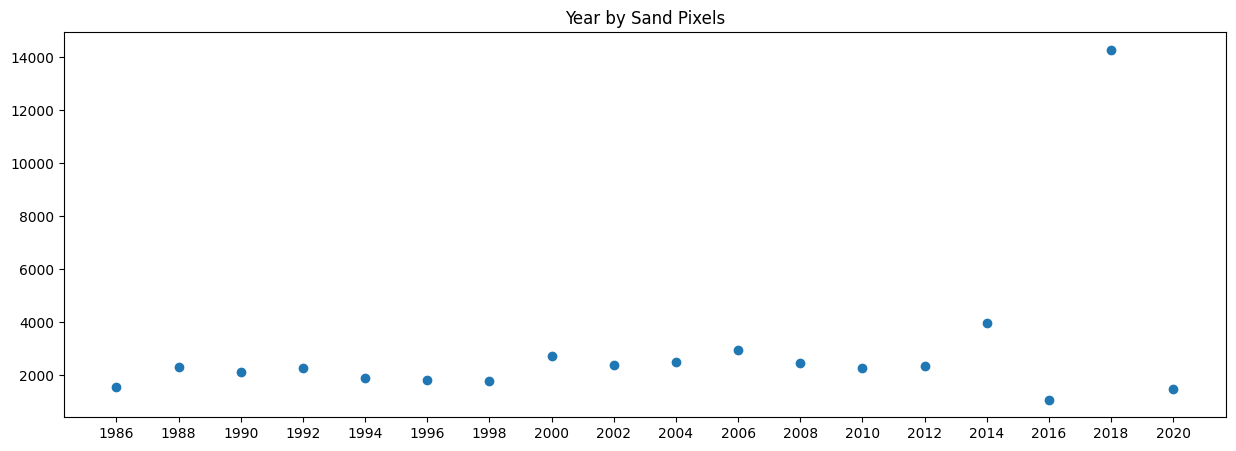

In [80]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(final_df['year'],final_df['SandPixles'])
ax.set_title('Year by Sand Pixels')
plt.show()

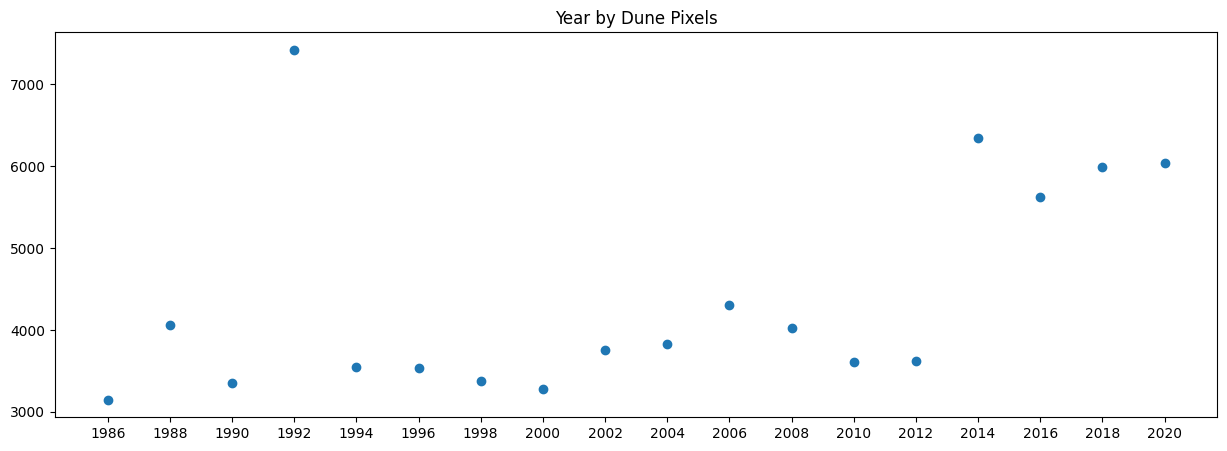

In [81]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(final_df['year'],final_df['DunePixles'])
ax.set_title('Year by Dune Pixels')
plt.show()

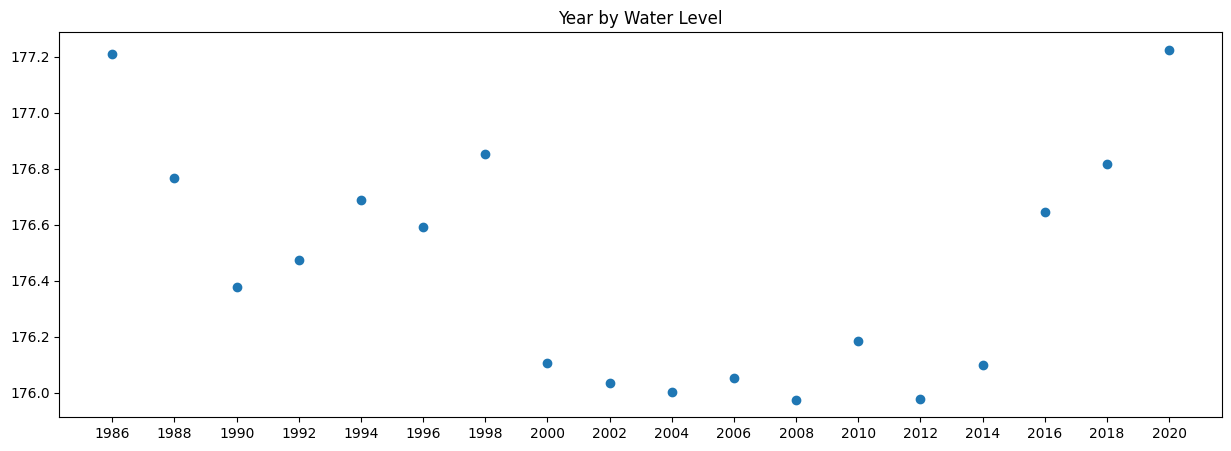

In [82]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(final_df['year'],final_df['water_level'])
ax.set_title('Year by Water Level')
plt.show()

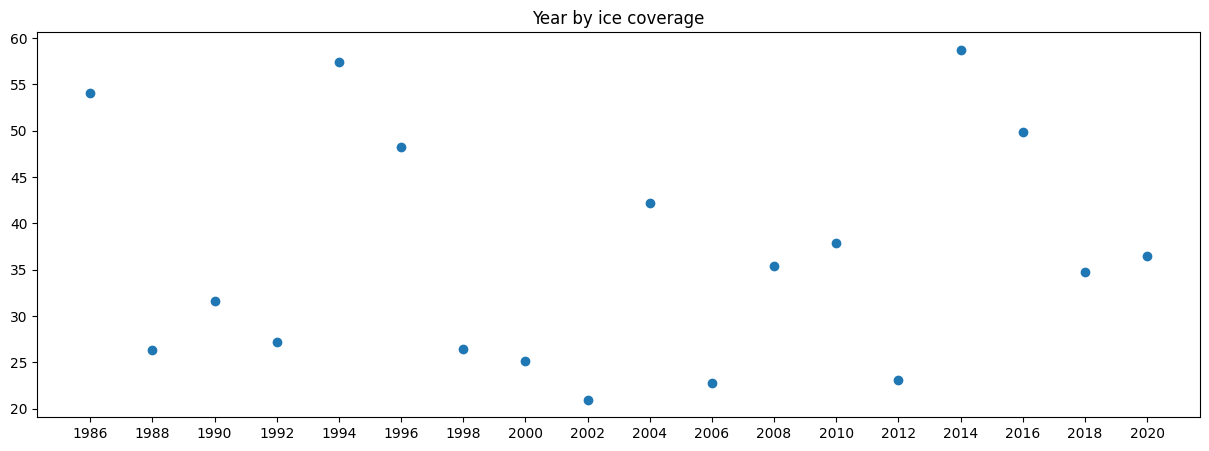

In [83]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(final_df['year'],final_df['cover'])
ax.set_title('Year by ice coverage')
plt.show()

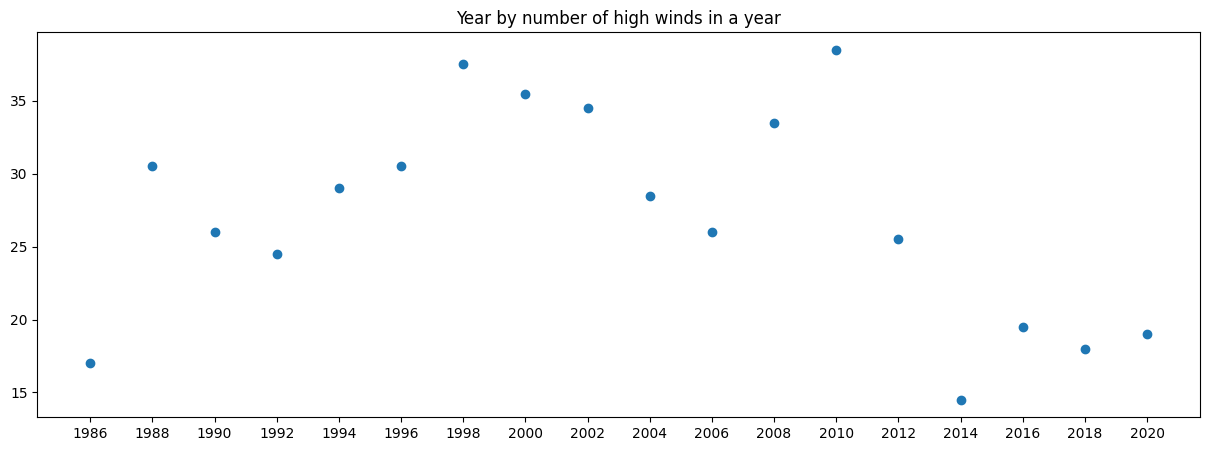

In [84]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(final_df['year'],final_df['number_of_events'])
ax.set_title('Year by number of high winds in a year')
plt.show()

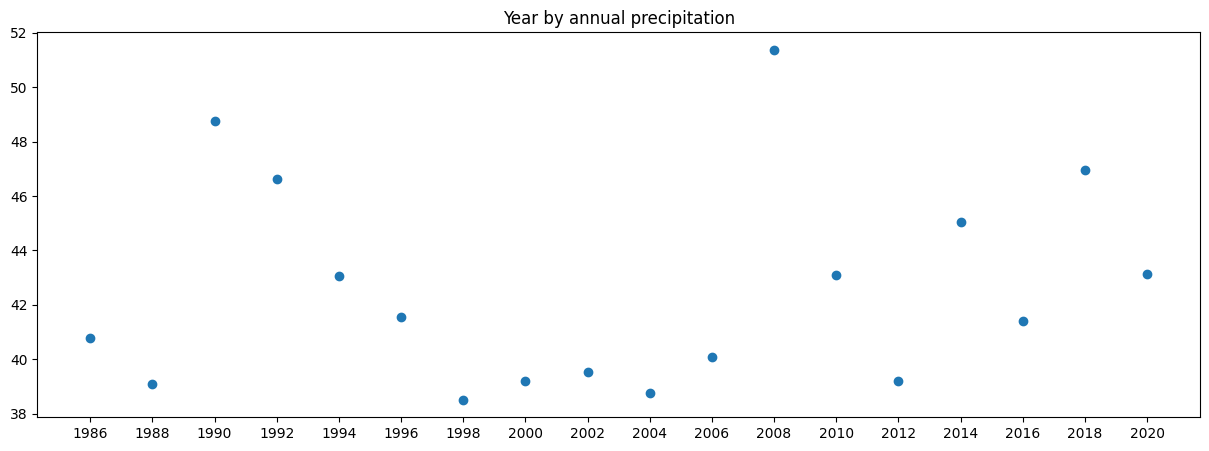

In [85]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(final_df['year'],final_df['Annual'])
ax.set_title('Year by annual precipitation')
plt.show()

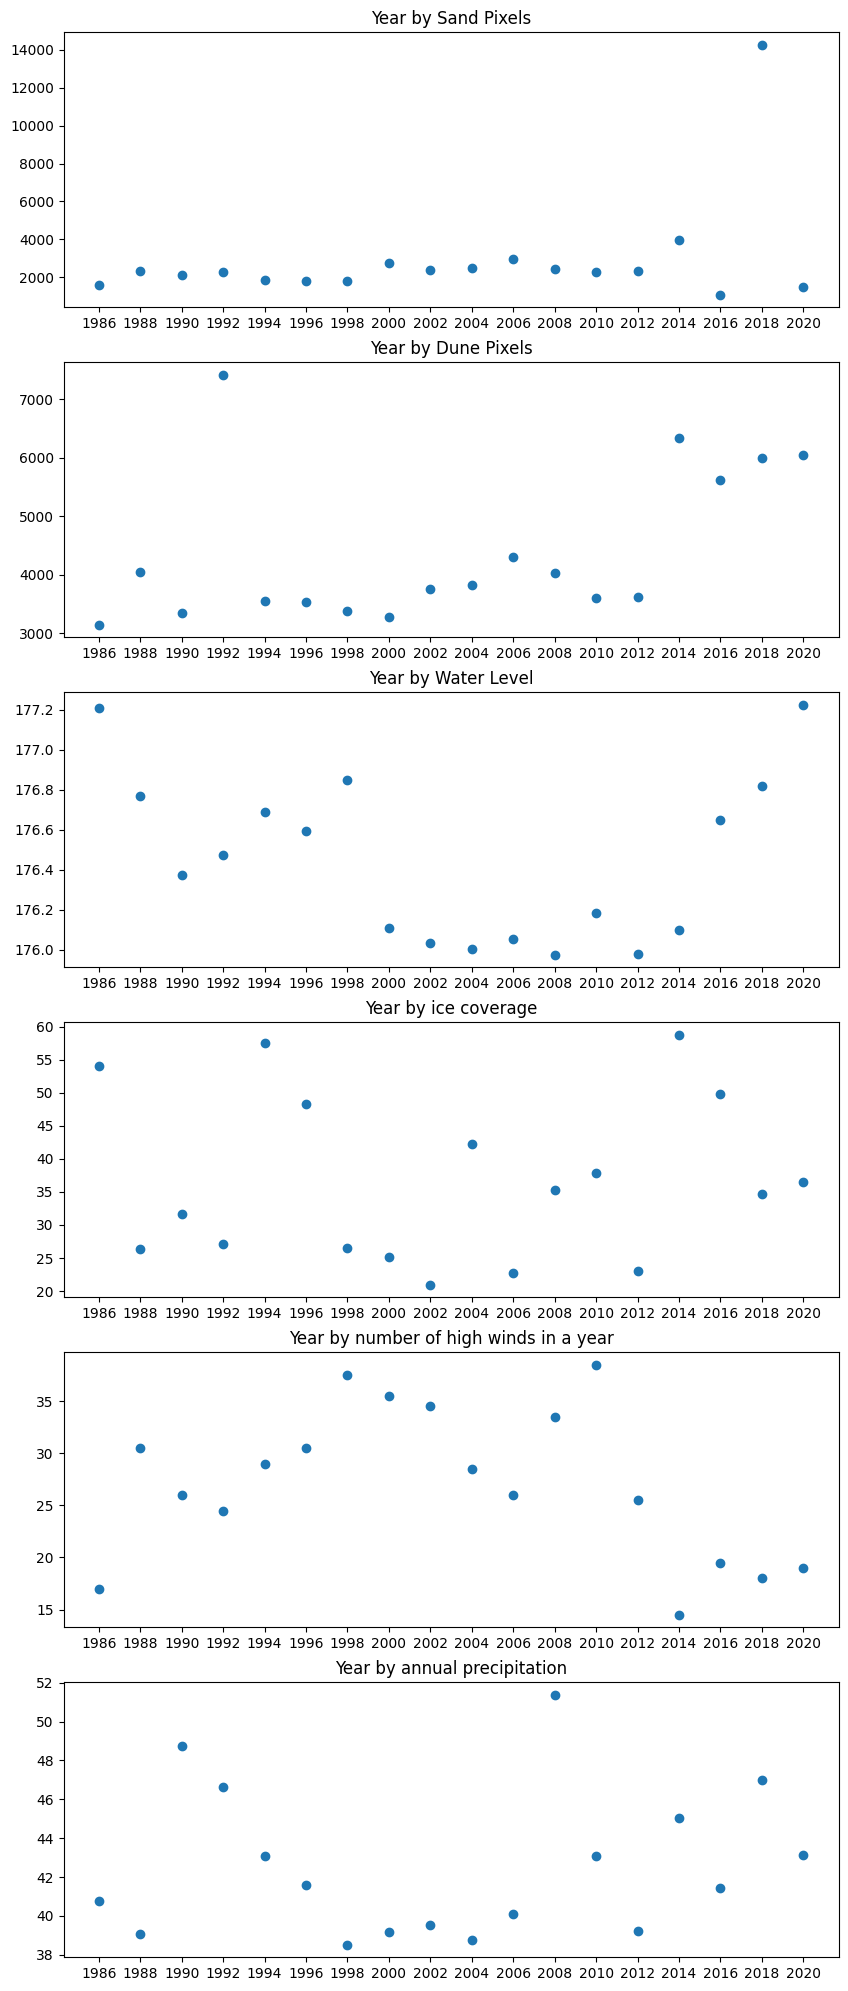

In [86]:
fig, ax = plt.subplots(6,1, figsize=(10, 25))

ax[0].scatter(final_df['year'],final_df['SandPixles'])
ax[0].set_title('Year by Sand Pixels')
ax[1].scatter(final_df['year'],final_df['DunePixles'])
ax[1].set_title('Year by Dune Pixels')
ax[2].scatter(final_df['year'],final_df['water_level'])
ax[2].set_title('Year by Water Level')
ax[3].scatter(final_df['year'],final_df['cover'])
ax[3].set_title('Year by ice coverage')
ax[4].scatter(final_df['year'],final_df['number_of_events'])
ax[4].set_title('Year by number of high winds in a year')
ax[5].scatter(final_df['year'],final_df['Annual'])
ax[5].set_title('Year by annual precipitation')
plt.show()

# Histograms

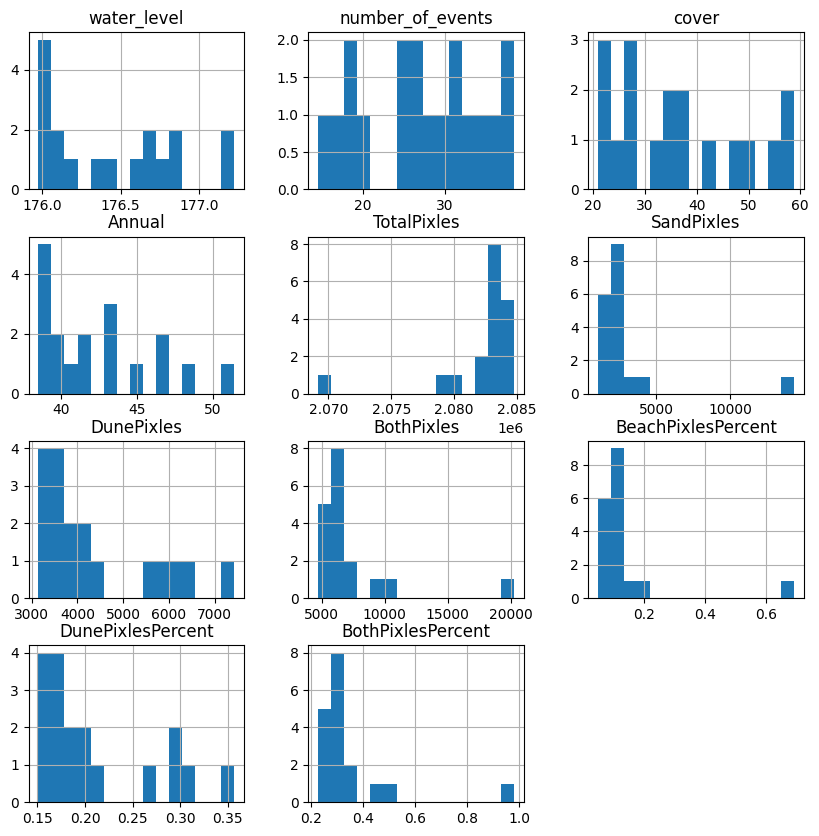

In [87]:
# Plot histogram: will need to adjust bins
final_df_hist = final_df.hist(bins=15 , figsize=(10, 10))

# Correlation Matrix

In [88]:
featureListSand = ['water_level', 'number_of_events', 'cover', 'Annual', 'SandPixles']
featureListDune = ['water_level', 'number_of_events', 'cover', 'Annual', 'DunePixles']
featureListBoth = ['water_level', 'number_of_events', 'cover', 'Annual', 'BothPixles']
corr_sand = final_df[featureListSand]
corr_dune = final_df[featureListDune]
corr_both = final_df[featureListBoth]

In [89]:
# Compute correlation matrix for sandPixles
sand_corr_matrix = corr_sand.corr()
sand_corr_matrix["SandPixles"].sort_values(ascending= False)

SandPixles          1.000000
Annual              0.305344
water_level         0.068513
cover              -0.060401
number_of_events   -0.303373
Name: SandPixles, dtype: float64

In [90]:
# Compute correlation matrix for dunePixles
dune_corr_matrix = corr_dune.corr()
dune_corr_matrix["DunePixles"].sort_values(ascending= False)

DunePixles          1.000000
Annual              0.388140
water_level         0.159995
cover               0.101625
number_of_events   -0.603652
Name: DunePixles, dtype: float64

In [91]:
# Compute correlation matrix
beach_and_dune_corr_matrix = corr_both.corr()
beach_and_dune_corr_matrix["BothPixles"].sort_values(ascending= False)

BothPixles          1.000000
Annual              0.390938
water_level         0.114186
cover              -0.012563
number_of_events   -0.467566
Name: BothPixles, dtype: float64

# Regression Modeling

### Regression modeling is not the best option for our data as we are limited on data. Going forward we want to include more years worth of data to create better modeling

In [92]:
featureList = ['water_level', 'number_of_events', 'cover', 'Annual']
X = final_df[featureList]
Ys = final_df['SandPixles']
Yd = final_df['DunePixles']
Yb = final_df['BothPixles']

In [93]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
df_scaled = pd.DataFrame(X_scaled, columns=featureList)

In [94]:
#split the data for sand
Xs_train, Xs_test, ys_train, ys_test = train_test_split(df_scaled, Ys, test_size=0.2, random_state=42)

#split the data for dune
Xd_train, Xd_test, yd_train, yd_test = train_test_split(df_scaled, Yd, test_size=0.2, random_state=42)

#split the data for both
Xb_train, Xb_test, yb_train, yb_test = train_test_split(df_scaled, Yb, test_size=0.2, random_state=42)

# Linear Regression

In [95]:
lin = LinearRegression()

lin.fit(Xs_train, ys_train)
predictionsSand = lin.predict(Xs_test)
mseSand = mean_squared_error(ys_test, predictionsSand)
rmseSand = np.sqrt(mseSand)
print(rmseSand)

1138.0459427705468


In [96]:
lin = LinearRegression()

lin.fit(Xd_train, yd_train)
predictionsDune = lin.predict(Xd_test)
mseDune = mean_squared_error(yd_test, predictionsDune)
rmseDune = np.sqrt(mseDune)
print(rmseDune)

1449.695460890477


In [97]:
lin = LinearRegression()

lin.fit(Xb_train, yb_train)
predictionsBoth = lin.predict(Xb_test)
mseDune = mean_squared_error(yb_test, predictionsBoth)
rmseDune = np.sqrt(mseDune)
print(rmseDune)

2568.8654489863648


# Linear Regression Plots

### With a small amount of training and test data there is only a handful of data points being estimates

(0.0, 5000.0)

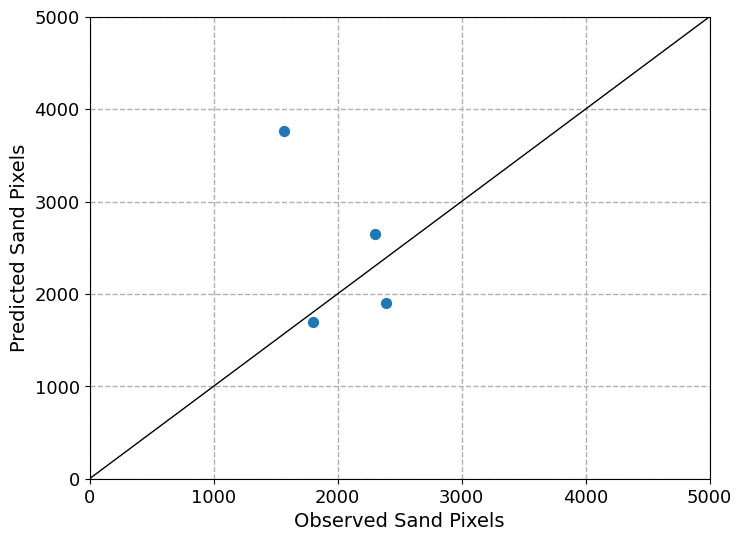

In [98]:
# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(ys_test, predictionsSand, alpha=1, s=50, zorder=2)
ax.plot([0,5000], [0, 5000], color='k', lw=1, zorder=3)
ax.set_ylabel('Predicted Sand Pixels', fontsize=14)
ax.set_xlabel('Observed Sand Pixels', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.grid(ls='dashed', lw=1, zorder=1)
ax.set_ylim(0,5000)
ax.set_xlim(0,5000)